In [187]:
library(tidyverse)
library(lmerTest)

### Preprocessing

Load data, subset to a few species, and store mean and sd stats for predictors.

In [188]:
data_path <- "data/tabular/phenology_pivot_long_231129.csv"

target_spp <- c("achillea millefolium", "balsamorhiza sagittata", "phacelia hastata")

data <- read.csv(data_path) %>% filter(species %in% target_spp)
data$species <- factor(data$species, levels = target_spp)

data$insolation_zscore <- scale(data$insolation)
data$tmean_zscore <- scale(data$tmean)

mean_sd <- function(x){
  c(mean(x),sd(x))
}

head(data)

,point,x,y,nearest_station,insolation,elevation,species,family,native,form,...,tmin,tmax,tmean,mean_first_flower,bins_becca,bins_meredith,bins_quantile,bins_kmeans,insolation_zscore,tmean_zscore
,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<int>,<chr>,...,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>"
1,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362
2,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362
3,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362
4,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362
5,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362
6,105,728810.9,5176590,Baldy Draw,3462.168,1327.388,achillea millefolium,asteraceae,1,forb,...,8.575926,19.68086,13.38395,167,middle,middle,late,middle,-0.01466502,0.3743362


### Visualize initial data

It appears that there is a tmean effect, but I'm not seeing an insolation effect.

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


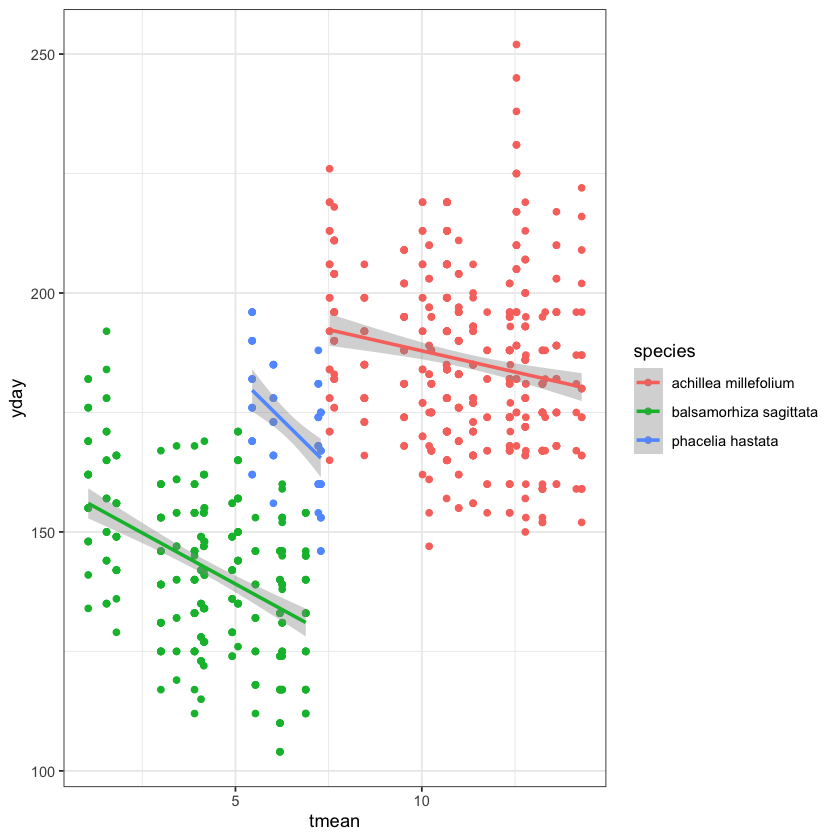

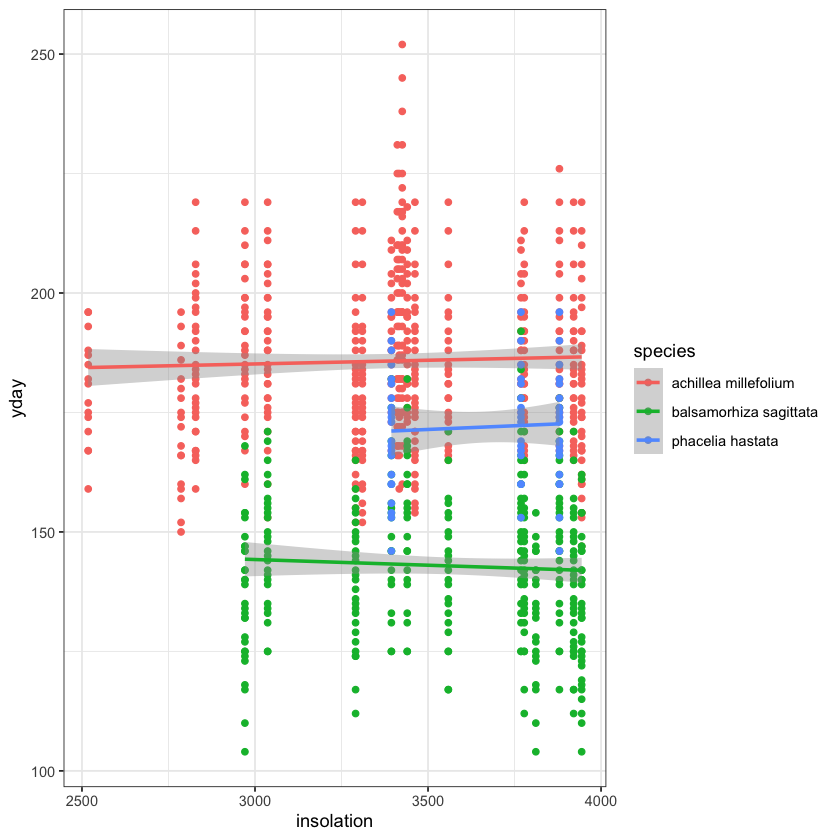

In [189]:
ggplot(data %>% filter(stage == 'flowering'), aes(x = tmean, y = yday, color = species)) +
  geom_point() +
  geom_smooth(method = "lm", se = T) +
  theme_bw()

ggplot(data %>% filter(stage == 'flowering'), aes(x = insolation, y = yday, color = species)) +
  geom_point() +
  geom_smooth(method = "lm", se = T) +
  theme_bw()

### Deviation coding helper function

This helper function takes as input a phenological stage as well as a model formula. It recodes the species factors and establishes different contrasts from the default. By default, each factor level is contrasted with a reference level, eg, treatment relative to a control. This doesn't make sense in our case. Instead I apply deviation coding, which contrasts each species to the mean forb condition. We'll get the mean slope of the main effects and environmental interactions, as well as species-level deviations from the mean. It returns a model object for further analysis. 

[See this UCLA stats documentation for further info on deviation coding.](https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#DEVIATION)

In [198]:
model_deviation_coding <- function(pheno_stage, model_formula){
  stage_data <- data %>% filter(stage == pheno_stage)

  num_species <- length(unique(stage_data$species))
  species_contrasts <- contr.sum(num_species)
  
  species_names <- levels(stage_data$species)
  last_level <- species_names[num_species]
  species_names <- species_names[species_names != last_level]

  colnames(species_contrasts) <- species_names
  contrasts(stage_data$species) <- species_contrasts
  
  if(str_detect(model_formula, '\\|')){
    print('Random effects detected')
    model <- lmer(model_formula, data = stage_data)
  }else{
    print('No random effects detected')
    model = lm(model_formula, data = stage_data)
  }
  return(model)
}

### Modeling 3-way interaction between environment and species
Below I specify a model formula that includes a three-way interaction between tmean, insolation, and species. I also include a random intercept for sampling point/site. This is to account for the temporal dependency arrising from repeated measure of the same site. Note that because the scale of insolation is on the 1e3 scale and temps are 1e1, I z-score these (subtract mean, divide by SD) to put them on similar scales to aid model fitting. Finally, I include a tidy table showing coefficients for main effects and interactions as well as p_values. 

In [ ]:
# 3-way interaction with random effect intercept for point due to repeated measures
flowering_formula_RE <- 'yday ~ tmean_zscore*insolation_zscore*species + (1|point)'
flowering_model_RE <- model_deviation_coding('flowering', flowering_formula_RE)

summary_tab <- as.data.frame(summary(flowering_model_RE)$coefficients)
colnames(summary_tab) <- c('estimate', 'SE', 'df', 't_value', 'p_value')

summary_tab <- summary_tab %>% 
  rownames_to_column(var = "effect") %>%
  select(effect, estimate, SE, df, t_value, p_value) %>%
  mutate(p_value = formatC(p_value, format = "e", digits = 2)) %>%
  mutate(p_value = as.numeric(p_value)) %>%
  mutate(
    effect = str_replace_all(effect, 'species', 'species=') %>%
      str_replace_all('tmean_zscore', 'tmean') %>%
      str_replace_all('insolation_zscore', 'insolation')
  ) %>%
  mutate(sig_code = case_when(p_value < 0.1 & p_value > 0.05 ~ '.',
                              p_value < 0.05 & p_value > 0.01 ~ '*',
                              p_value < 0.01 & p_value > 0.001 ~ '**',
                              p_value < 0.001 ~ '***',
                              TRUE ~ '')
  ) 

row.names(summary_tab) <- NULL

summary_tab


effect,estimate,SE,df,t_value,p_value,sig_code
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),140.6564745,6.216217,472.5660,22.62734439,2.42e-77,***
tmean,-27.6262917,4.752742,860.5407,-5.81270594,8.66e-09,***
insolation,-5.2767589,7.675132,713.3754,-0.68751379,4.92e-01,
species=achillea millefolium,40.6671869,5.788973,849.8152,7.02494029,4.39e-12,***
species=balsamorhiza sagittata,-40.6131945,6.564145,864.4501,-6.18712666,9.45e-10,***
tmean:insolation,-1.3235267,5.993295,856.9463,-0.22083456,8.25e-01,
tmean:species=achillea millefolium,2.2937111,4.818752,857.9555,0.47599687,6.34e-01,
tmean:species=balsamorhiza sagittata,0.9477224,4.872031,851.3103,0.19452305,8.46e-01,
insolation:species=achillea millefolium,1.3239110,7.371299,849.3375,0.17960349,8.58e-01,


### Visualizing model predictions
Here I generate species-level predictions for a range of tmean values. Because we didn't find an insolation effect, I simply set insolation to the mean observed insolation value.

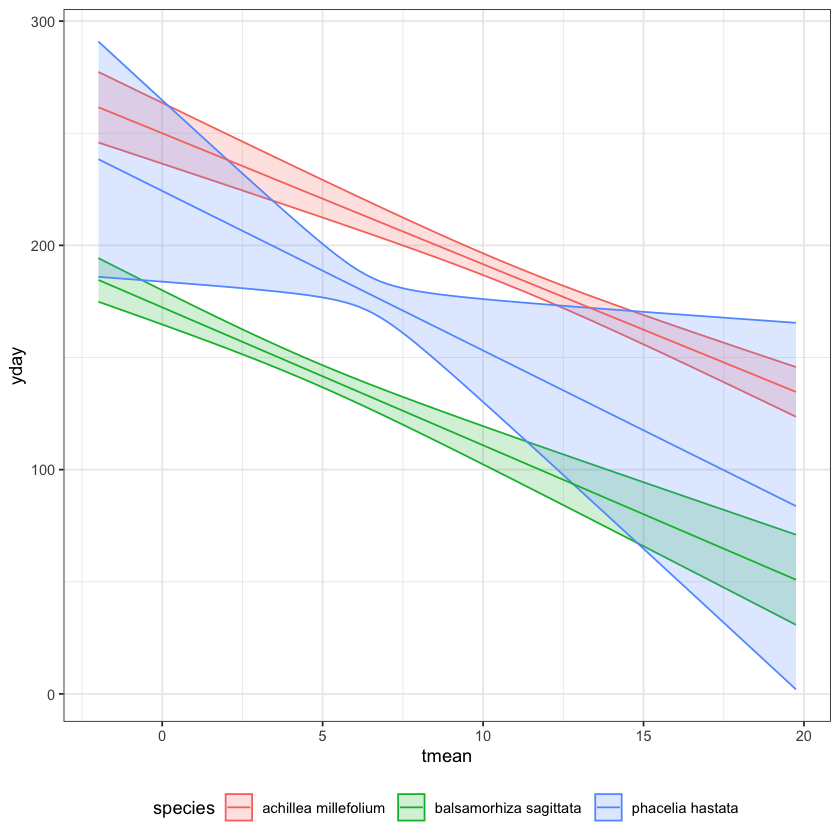

In [ ]:
# Set the mean value of insolation
mean_insolation <- mean(data$insolation)
tmean_values <- seq(min(data$tmean), max(data$tmean), length.out = 100)

stats_insolation <- mean_sd(data$insolation)
stats_tmean <- mean_sd(data$tmean)

new_data <- data.frame(
  expand.grid(
    tmean = tmean_values, 
    insolation = mean_insolation, 
    species = target_spp
  )
) %>%
  mutate(
    tmean_zscore = (tmean - stats_tmean[1]) / stats_tmean[2], # z-score new data based upon original stats
    insolation_zscore = (insolation - stats_insolation[1]) / stats_insolation[2],
  )

predictions_with_se <- predict(flowering_model_RE, newdata = new_data, re.form = NA, se.fit = TRUE)

# Calculate upper and lower bounds of the confidence intervals
# Assuming a 95% confidence interval, hence using 1.96 for the Z value
ci_width <- 1.96 * predictions_with_se$se.fit
predictions_df <- data.frame(new_data, 
                             yday = predictions_with_se$fit, 
                             lower = predictions_with_se$fit - ci_width, 
                             upper = predictions_with_se$fit + ci_width)

# Plot the predictions with confidence intervals
ggplot(predictions_df, aes(x = tmean, y = yday, color = species)) +
  geom_ribbon(aes(ymin = lower, ymax = upper, fill = species), alpha = 0.2) + # Add shaded confidence intervals
  geom_line() + # Add the prediction lines
  labs(x = "tmean", y = "yday") +
  theme_bw() +
  theme(legend.position = "bottom")